<a href="https://colab.research.google.com/github/angelmorales2621-gif/simulaci-n2/blob/main/2_servidores.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Actualmente una gasolinera tiene 2 bombas,
los vehículos llegan al sistema con un promedio de 1 cada 10 minutos, cada vehículo requiere de un promedio de 5 minutos para ser atendido. Supóngase que los vehículos llegan de acuerdo con una distribución Poisson y que el tiempo necesario para prestar el servicio se distribuye en forma exponencial.

1.  a) Determine la razón de utilización del sistema. ( ρ )
2.  b) ¿Cuál es la probabilidad de que un cliente llegue y no tenga que esperar?
3.   c) ¿Cuál es la probabilidad de que todas las bombas estén ocupadas?
4. d) ¿Cuánto tiempo pasa un vehículo en promedio dentro de la gasolinera (desde que llega hasta que termina de cargar)?
5. e) ¿Cuál es el número promedio de vehículos esperando en la fila?
6. f) ¿Cuál es el número promedio de vehículos en toda la instalación?

Datos del problema:


*   Tasa de llegadas: $\lambda = \frac{1}{10} = 6$ vehículos/hora
*   Tiempo promedio de servicio: $\mu = \frac{1}{5} = 12$ vehículos/hora
* Número de bombas (servidores): s=2



1. a) Determine la razón de utilización del sistema. ( ρ ):
$\rho = \frac{\lambda}{s\mu} = \frac{6}{2(12)} = 0.25$  
  
2. b) Probabilidad de que un cliente no tenga que esperar: Primero calculamos $( a = \frac{\lambda}{\mu})$:$a = \frac{6}{12} = 0.5$  
  
La probabilidad de que el sistema esté vacío es: $P_0 = \left[ \sum_{n=0}^{s-1} \frac{a^n}{n!} +
\frac{a^s}{s!(1-\rho)} \right]^{-1}$  
$P_0 = \left[ 1 + 0.5 + \frac{0.5^2}{2(1-0.25)} \right]^{-1}
= \left[ 1.6667 \right]^{-1} = 0.6$  
  
La probabilidad de no esperar es: $P(\text{no espera}) = P_0 (1 + a) = 0.6(1.5) = 0.9$


3.   c) ¿Cuál es la probabilidad de que todas las bombas estén ocupadas?  
$P(\text{todas ocupadas}) =
\frac{a^s}{s!(1-\rho)} P_0
= \frac{0.5^2}{2(0.75)}(0.6) = 0.1$  
  
4. d) ¿Cuánto tiempo pasa un vehículo en promedio dentro de la gasolinera (desde que llega hasta que termina de cargar)?  
Número promedio de vehículos en cola: $L_q = P(\text{todas ocupadas}) \frac{\rho}{1-\rho}
= 0.1 \frac{0.25}{0.75} = 0.0333$  
Tiempo promedio de espera en cola: $W_q = \frac{L_q}{\lambda} = \frac{0.0333}{6} = 0.00556 $ horas   
Tiempo promedio total en el sistema: $W = W_q + \frac{1}{\mu} = 0.00556 + \frac{1}{12} = 0.0889$ horas

5. e) ¿Cuál es el número promedio de vehículos esperando en la fila?  
Número promedio de vehículos en la fila: $L_q = 0.0333$ vehículos  
  
6. f) ¿Cuál es el número promedio de vehículos en toda la instalación?
Número promedio de vehículos en la instalación: $L = \lambda W = 0.1(5.3333) = 0.5333$ vehículos

In [2]:
!pip install simpy

--- RESULTADOS (2 BOMBAS) ---
a) Razón de utilización (rho): 0.2500
b) Probabilidad de no esperar: 0.8981
c) Probabilidad de todas las bombas ocupadas: 0.1019
d) Tiempo promedio en la gasolinera (W): 5.4001 min
e) Número promedio de vehículos en fila (Lq): 0.0380
f) Número promedio de vehículos en la instalación (L): 0.5328


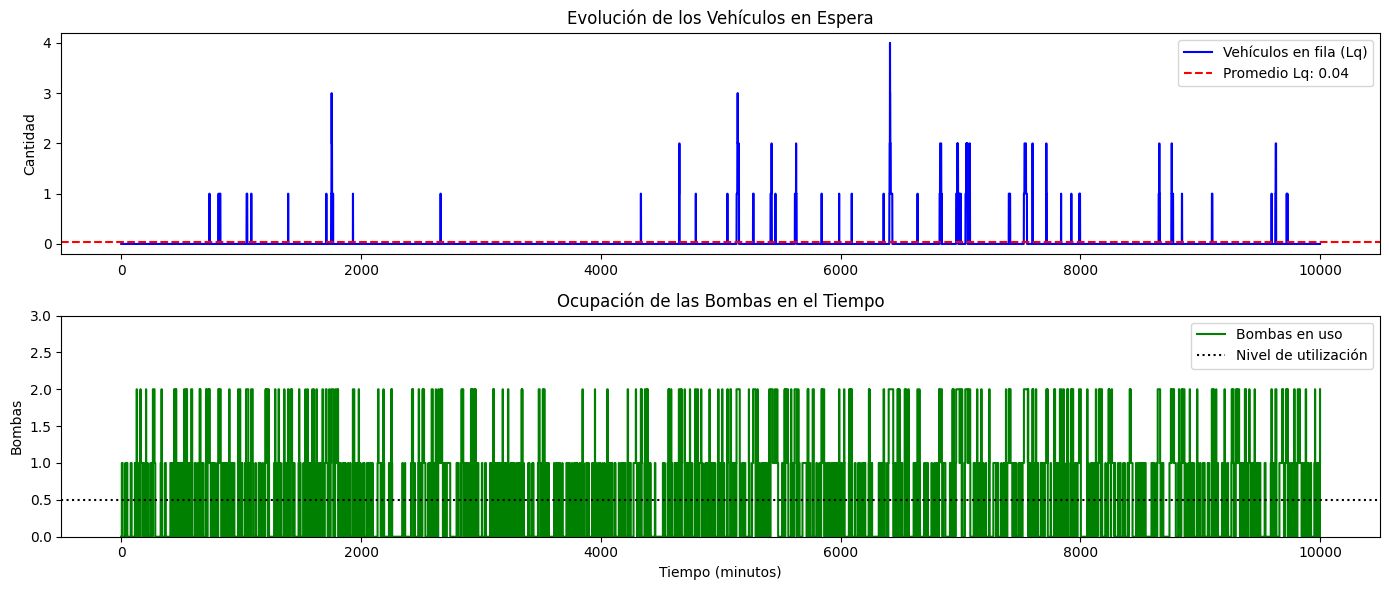

In [6]:
import simpy
import numpy as np
import matplotlib.pyplot as plt

# --- DATOS ---
SEMILLA = 42
NUM_BOMBAS = 2
TIEMPO_LLEGADA_PROMEDIO = 10.0  # Lambda = 0.1 vehículos/min
TIEMPO_SERVICIO_PROMEDIO = 5.0   # Mu = 0.2 servicios/min
TIEMPO_SIMULACION = 10000        # Minutos a simular

# Amacén de los datos
tiempo_en_sistema = []
tiempos_en_fila = []
tamaño_cola = []
bombas_ocupadas = []
tiempo = []

def vehiculo(env, gasolinera):
    llegada = env.now

    with gasolinera.request() as request:
        yield request  # Espera hasta que una bomba esté libre

        espera = env.now - llegada
        tiempos_en_fila.append(espera)

        # Servicio con distribución exponencial
        tiempo_servicio = np.random.exponential(TIEMPO_SERVICIO_PROMEDIO)
        yield env.timeout(tiempo_servicio)

        # Tiempo total: desde que llega hasta que termina
        tiempo_en_sistema.append(env.now - llegada)

def generador_vehiculos(env, gasolinera):
    while True:
        # Llegadas Poisson (intervalos exponenciales)
        yield env.timeout(np.random.exponential(TIEMPO_LLEGADA_PROMEDIO))
        env.process(vehiculo(env, gasolinera))

def monitor(env, gasolinera):
    while True:
        tamaño_cola.append(len(gasolinera.queue))
        bombas_ocupadas.append(gasolinera.count)
        tiempo.append(env.now)
        yield env.timeout(1) # Muestreo cada minuto

# --- EJECUCIÓN ---
np.random.seed(SEMILLA)
env = simpy.Environment()
gasolinera = simpy.Resource(env, capacity=NUM_BOMBAS)

env.process(generador_vehiculos(env, gasolinera))
env.process(monitor(env, gasolinera))
env.run(until=TIEMPO_SIMULACION)

# --- RESULTADOS ---
total_muestras = len(bombas_ocupadas)
p0 = bombas_ocupadas.count(0) / total_muestras
p1 = bombas_ocupadas.count(1) / total_muestras
p2 = bombas_ocupadas.count(2) / total_muestras

# a) Utilización rho = lambda / (s * mu)
rho = (TIEMPO_SERVICIO_PROMEDIO / TIEMPO_LLEGADA_PROMEDIO) / NUM_BOMBAS

# b) No esperar: hay 0 o 1 ocupado cuando llega
prob_no_esperar = p0 + p1

# c) Todas ocupadas: hay 2 bombas en uso
prob_todas_ocupadas = p2

# d) Tiempo promedio en sistema (W)
W = np.mean(tiempo_en_sistema)

# e) Número promedio en fila (Lq)
Lq = np.mean(tamaño_cola)

# f) Número promedio en instalación (L)
# L = Lq + (lambda / mu) -> En promedio: vehículos en cola + vehículos siendo atendidos
L = Lq + np.mean(bombas_ocupadas)

# --- RESULTADOS incisos ---
print(f"--- RESULTADOS ({NUM_BOMBAS} BOMBAS) ---")
print(f"a) Razón de utilización (rho): {rho:.4f}")
print(f"b) Probabilidad de no esperar: {prob_no_esperar:.4f}")
print(f"c) Probabilidad de todas las bombas ocupadas: {prob_todas_ocupadas:.4f}")
print(f"d) Tiempo promedio en la gasolinera (W): {W:.4f} min")
print(f"e) Número promedio de vehículos en fila (Lq): {Lq:.4f}")
print(f"f) Número promedio de vehículos en la instalación (L): {L:.4f}")

# --- GRÁFICAS ---
plt.figure(figsize=(14, 6))

# Gráfica de evolución de la fila
plt.subplot(2, 1, 1)
plt.plot(tiempo, tamaño_cola, color='blue', label='Vehículos en fila (Lq)')
plt.axhline(y=Lq, color='red', linestyle='--', label=f'Promedio Lq: {Lq:.2f}')
plt.title("Evolución de los Vehículos en Espera")
plt.ylabel("Cantidad")
plt.legend()

# Gráfica de ocupación de bombas
plt.subplot(2, 1, 2)
plt.step(tiempo, bombas_ocupadas, color='green', where='post', label='Bombas en uso')
plt.axhline(y=NUM_BOMBAS * rho * NUM_BOMBAS / NUM_BOMBAS, color='black', linestyle=':', label='Nivel de utilización')
plt.title("Ocupación de las Bombas en el Tiempo")
plt.xlabel("Tiempo (minutos)")
plt.ylabel("Bombas")
plt.ylim(0, NUM_BOMBAS + 1)
plt.legend()

plt.tight_layout()
plt.show()